In [1]:
# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (32,32)  #Default to (256,266), use (None,None) if you do not want to resize imgs

In [7]:
# Import all the necessary libraries
import os
import datetime
import glob
import random
import sys

import matplotlib.pyplot as plt
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
from skimage.morphology import label                  #Used for Run-Length-Encoding RLE to create final submission

import numpy as np
import pandas as pd

import keras
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import add, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import multi_gpu_model, plot_model
from keras import backend as K
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)


/Users/wajdiahmed/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/wajdiahmed/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Python       : 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
Numpy        : 1.14.2
Skimage      : 0.13.1
Scikit-learn : 0.19.1
Keras        : 2.1.6
Tensorflow   : 1.10.1


In [3]:
%%time
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

CPU times: user 14 µs, sys: 4 µs, total: 18 µs
Wall time: 21.9 µs


In [5]:
%%time
#/Users/wajdiahmed/Kaggle/Square_cut/
# Have a look at our data folder
topDir = '/Users/wajdiahmed/Kaggle' #defaults to '/kaggle' in kaggle kernels, different if on own system e.g. '/home/user/kaggle/dsbowl'
os.chdir(topDir)    #changes our python working directory to the top directory of our kaggle files
print(os.listdir(os.path.join(topDir, '')))  #see what's in the input folder (where data is in)

['.DS_Store', 'TCGA Data', 'stage1_solution.csv', 'NewData', 'extra_data', 'stage2_test_final', 'Thes_Antonyms_a-z.csv', 'stage1_test', 'stage1_sample_submission.csv', 'stage1_train', 'Square_cut_v1', 'Square_cut', 'mask.psd', 'stage1_train_labels.csv', 'mask.png', 'Single_Cut', 'stage2_sample_submission_final.csv', 'image.png']
CPU times: user 392 µs, sys: 604 µs, total: 996 µs
Wall time: 461 µs


In [36]:
%%time
train_path = os.path.join(topDir, 'Square_cut')  #path to training data file/folder
test_path = os.path.join(topDir, 'stage1_test copy')   #path to test data file/folder
print('Done...')

Done...
CPU times: user 345 µs, sys: 635 µs, total: 980 µs
Wall time: 677 µs


In [8]:
%%time
# Get training data

def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    print('Done...')
    return X_data
X_train = get_X_data(train_path, output_shape=(img_height,img_width))
print(X_train.shape, X_train.dtype)


Done...
(46427, 32, 32, 3) uint8
CPU times: user 53.7 s, sys: 8.61 s, total: 1min 2s
Wall time: 5min 49s


In [9]:
%%time
# Get training data labels
def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data
Y_train = get_Y_data(train_path, output_shape=(img_height,img_width))
print(Y_train.shape, Y_train.dtype)

(46427, 32, 32, 1) bool
CPU times: user 24.9 s, sys: 6.61 s, total: 31.5 s
Wall time: 1min 11s


(32, 32, 3)


/Users/wajdiahmed/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


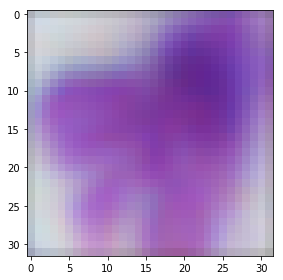

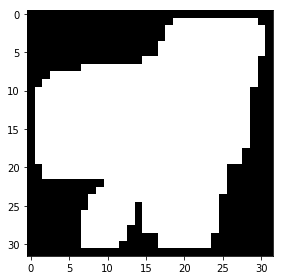

In [33]:
id = 1
print(X_train[id].shape)
skimage.io.imshow(X_train[id])
plt.show()
skimage.io.imshow(Y_train[id][:,:,0])
plt.show()

In [11]:
# Design our model architecture here
def keras_model(img_width=256, img_height=256):
    '''
    Modified from https://keunwoochoi.wordpress.com/2017/10/11/u-net-on-keras-2-0/
    '''
    n_ch_exps = [4, 5, 6, 7, 8, 9]   #the n-th deep channel's exponent i.e. 2**n 16,32,64,128,256
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer

    if K.image_data_format() == 'channels_first':
        ch_axis = 1
        input_shape = (3, img_width, img_height)
    elif K.image_data_format() == 'channels_last':
        ch_axis = 3
        input_shape = (img_width, img_height, 3)

    inp = Input(shape=input_shape)
    encodeds = []

    # encoder
    enc = inp
    print(n_ch_exps)
    for l_idx, n_ch in enumerate(n_ch_exps):
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        enc = Dropout(0.1*l_idx,)(enc)
        enc = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(enc)
        encodeds.append(enc)
        #print(l_idx, enc)
        if n_ch < n_ch_exps[-1]:  #do not run max pooling on the last encoding/downsampling step
            enc = MaxPooling2D(pool_size=(2,2))(enc)
    
    # decoder
    dec = enc
    print(n_ch_exps[::-1][1:])
    decoder_n_chs = n_ch_exps[::-1][1:]
    for l_idx, n_ch in enumerate(decoder_n_chs):
        l_idx_rev = len(n_ch_exps) - l_idx - 2  #
        dec = Conv2DTranspose(filters=2**n_ch, kernel_size=k_size, strides=(2,2), activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = concatenate([dec, encodeds[l_idx_rev]], axis=ch_axis)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)
        dec = Dropout(0.1*l_idx)(dec)
        dec = Conv2D(filters=2**n_ch, kernel_size=k_size, activation='relu', padding='same', kernel_initializer=k_init)(dec)

    outp = Conv2DTranspose(filters=1, kernel_size=k_size, activation='sigmoid', padding='same', kernel_initializer='glorot_normal')(dec)

    model = Model(inputs=[inp], outputs=[outp])
    
    return model

In [12]:
# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [13]:
# Set some model compile parameters
optimizer = 'adam'
loss      = bce_dice_loss
metrics   = [mean_iou]

# Compile our model
model = keras_model(img_width=img_width, img_height=img_height)
model.summary()

# For more GPUs
if num_gpus > 1:
    model = multi_gpu_model(model, gpus=num_gpus)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   2320        dropout_1[0][0]                  
__________________________________________________________________________

In [14]:
# Runtime data augmentation
def get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.25, batch_size=32, seed=seed):
    X_train, X_test, Y_train, Y_test = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True, seed=seed)
    Y_datagen_val.fit(Y_test, augment=True, seed=seed)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True, seed=seed)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator

In [16]:
# Runtime custom callbacks
#%% https://github.com/deepsense-ai/intel-ai-webinar-neural-networks/blob/master/live_loss_plot.py
# Fixed code to enable non-flat loss plots on keras model.fit_generator()
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center left')
        
        plt.tight_layout()
        plt.show();

plot_losses = PlotLosses(figsize=(16, 4))

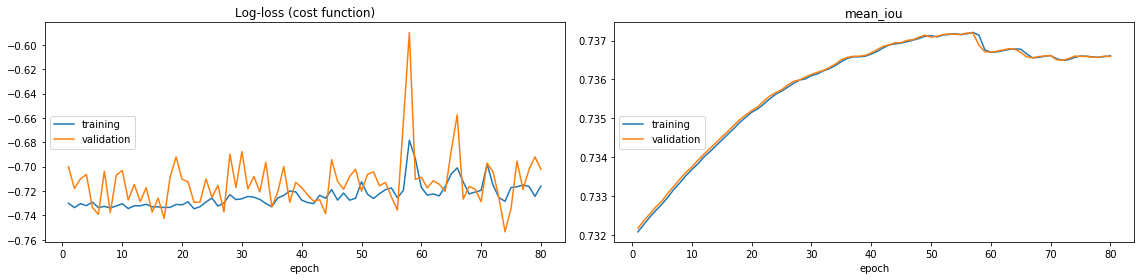

In [35]:
# Finally train the model!!
batch_size = 32

train_generator, test_generator = get_train_test_augmented(X_data=X_train, Y_data=Y_train, validation_split=0.11, batch_size=batch_size)
model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=80, callbacks=[plot_losses])

In [37]:
# Save the model weights to a hdf5 file
if num_gpus > 1:
    #Refer to https://stackoverflow.com/questions/41342098/keras-load-checkpoint-weights-hdf5-generated-by-multiple-gpus
    #model.summary()
    model_out = model.layers[-2]  #get second last layer in multi_gpu_model i.e. model.get_layer('model_1')
else:
    model_out = model
model_out.save_weights(filepath=topDir+"model-weights2.hdf5")

In [38]:
# Reload the model
model_loaded = keras_model(img_width=img_width, img_height=img_height)
model_loaded.load_weights(topDir+"model-weights2.hdf5")

[4, 5, 6, 7, 8, 9]
[8, 7, 6, 5, 4]


In [40]:
# Get test data
X_test = get_X_data(test_path, output_shape=(img_height,img_width))

Done...


In [41]:
# Use model to predict test labels
Y_hat = model_loaded.predict(X_test, verbose=1)
Y_hat.shape

7/7 [==============================] - 0s 51ms/step


(7, 32, 32, 1)

In [9]:
id = 5

skimage.io.imshow(X_test[id])
plt.show()
skimage.io.imshow(Y_hat[id][:,:,0])
plt.show()

NameError: name 'X_test' is not defined